<a href="https://colab.research.google.com/github/anandhij123/HeartAttackprediction/blob/main/Heartattack_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# ----------------------------
# Step 1: Load the Dataset
# ----------------------------
path = "/content/sample_data/heart_attack_dataset.csv"

try:
    df = pd.read_csv(path)
    print("Dataset loaded successfully.\n")
except FileNotFoundError:
    print(f"File not found at the specified path: {path}")
    exit()



Dataset loaded successfully.



In [ ]:
# ----------------------------
# Step 2: Explore the Dataset
# ----------------------------
print("First 5 rows of the dataset:")
print(df.head(), "\n")

print("Last 5 rows of the dataset:")
print(df.tail(), "\n")

print("Column names:")
print(df.columns, "\n")

print("DataFrame Info:")
print(df.info(), "\n")

print("Descriptive Statistics:")
print(df.describe(), "\n")

print("Missing Values in Each Column:")
print(df.isnull().sum(), "\n")


First 5 rows of the dataset:
   Gender  Age  Blood Pressure (mmHg)  Cholesterol (mg/dL) Has Diabetes  \
0    Male   70                    181                  262           No   
1  Female   55                    103                  253          Yes   
2    Male   42                     95                  295          Yes   
3    Male   84                    106                  270           No   
4    Male   86                    187                  296          Yes   

  Smoking Status   Chest Pain Type                            Treatment  
0          Never    Typical Angina                    Lifestyle Changes  
1          Never   Atypical Angina                          Angioplasty  
2        Current    Typical Angina                          Angioplasty  
3          Never   Atypical Angina  Coronary Artery Bypass Graft (CABG)  
4        Current  Non-anginal Pain                           Medication   

Last 5 rows of the dataset:
     Gender  Age  Blood Pressure (mmHg)  Chole

In [ ]:
# ----------------------------
# Step 3: Data Preprocessing
# ----------------------------
df.fillna(df.mean(numeric_only=True), inplace=True)
print("Missing Values After Imputation:")
print(df.isnull().sum(), "\n")

# ----------------------------
# Step 4: Encode Categorical Variables
# ----------------------------
le_gender = LabelEncoder()
le_smoking = LabelEncoder()
le_cpt = LabelEncoder()
le_treatment = LabelEncoder()
le_diabetes = LabelEncoder()

df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Smoking_Status_Encoded'] = le_smoking.fit_transform(df['Smoking Status'])
df['Chest_Pain_Type_Encoded'] = le_cpt.fit_transform(df['Chest Pain Type'])
df['Treatment_Encoded'] = le_treatment.fit_transform(df['Treatment'])
df['Has_Diabetes_Encoded'] = le_diabetes.fit_transform(df['Has Diabetes'])

print("Updated Columns with Encoded Values:")
print(df.columns, "\n")


Missing Values After Imputation:
Gender                   0
Age                      0
Blood Pressure (mmHg)    0
Cholesterol (mg/dL)      0
Has Diabetes             0
Smoking Status           0
Chest Pain Type          0
Treatment                0
dtype: int64 

Updated Columns with Encoded Values:
Index(['Gender', 'Age', 'Blood Pressure (mmHg)', 'Cholesterol (mg/dL)',
       'Has Diabetes', 'Smoking Status', 'Chest Pain Type', 'Treatment',
       'Gender_Encoded', 'Smoking_Status_Encoded', 'Chest_Pain_Type_Encoded',
       'Treatment_Encoded', 'Has_Diabetes_Encoded'],
      dtype='object') 



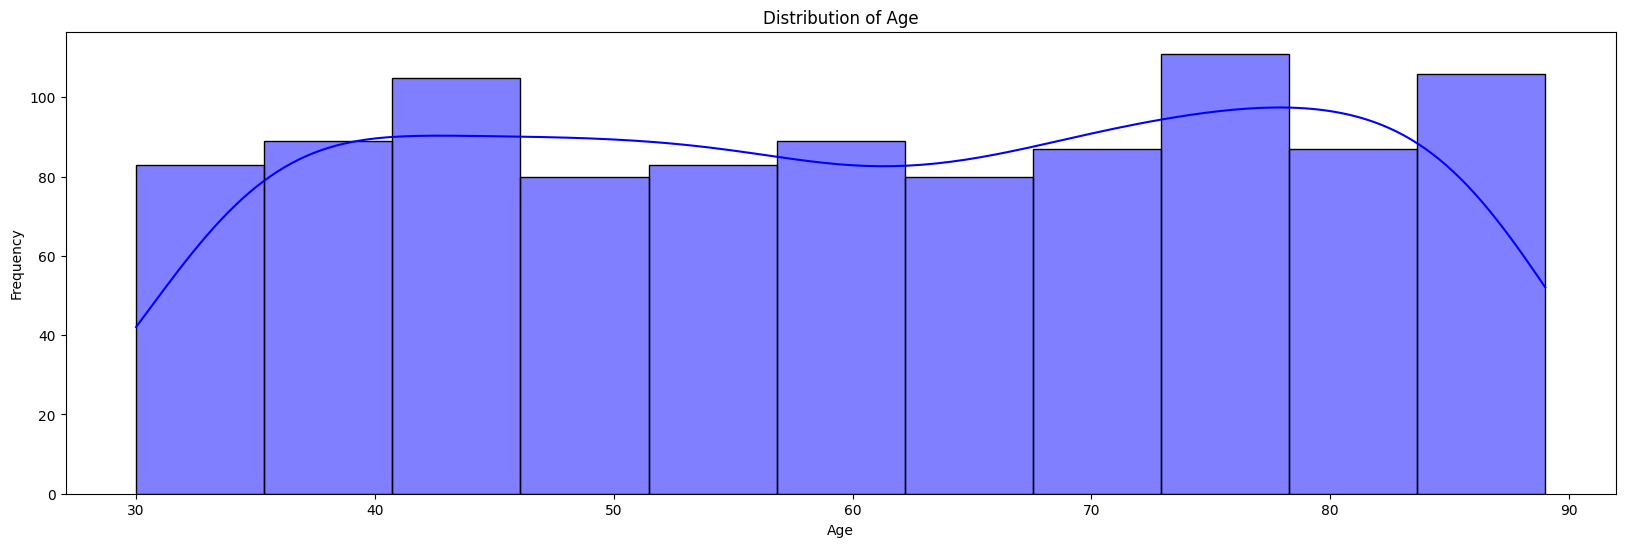

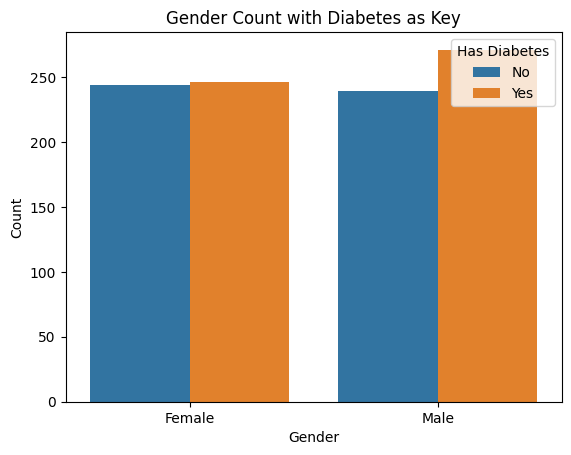

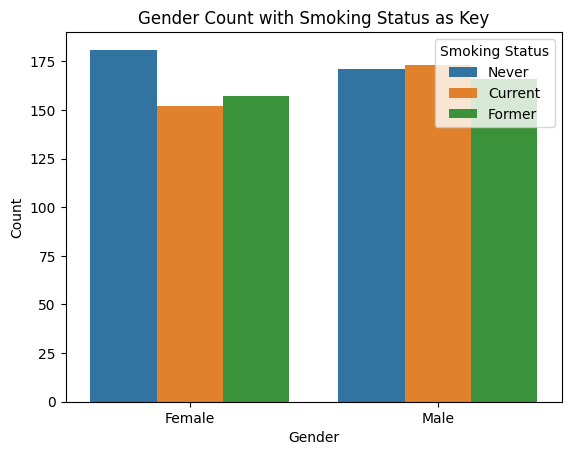

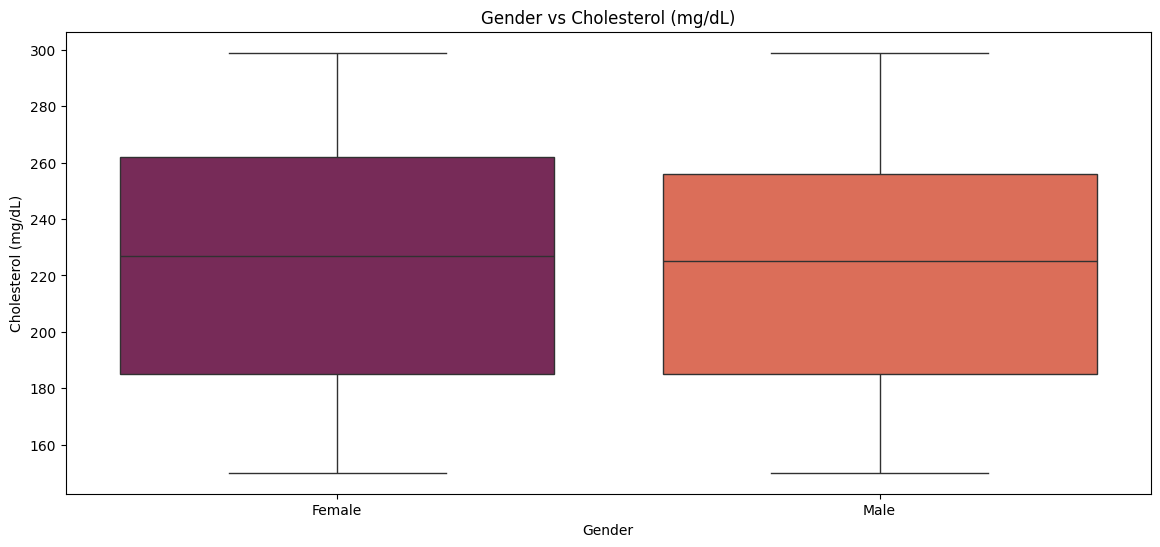

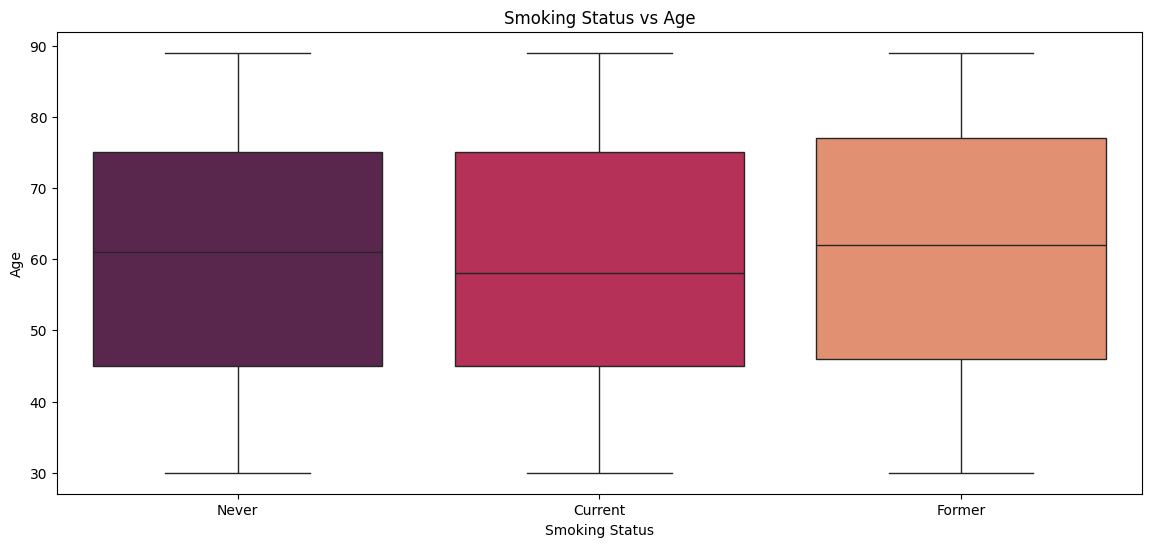

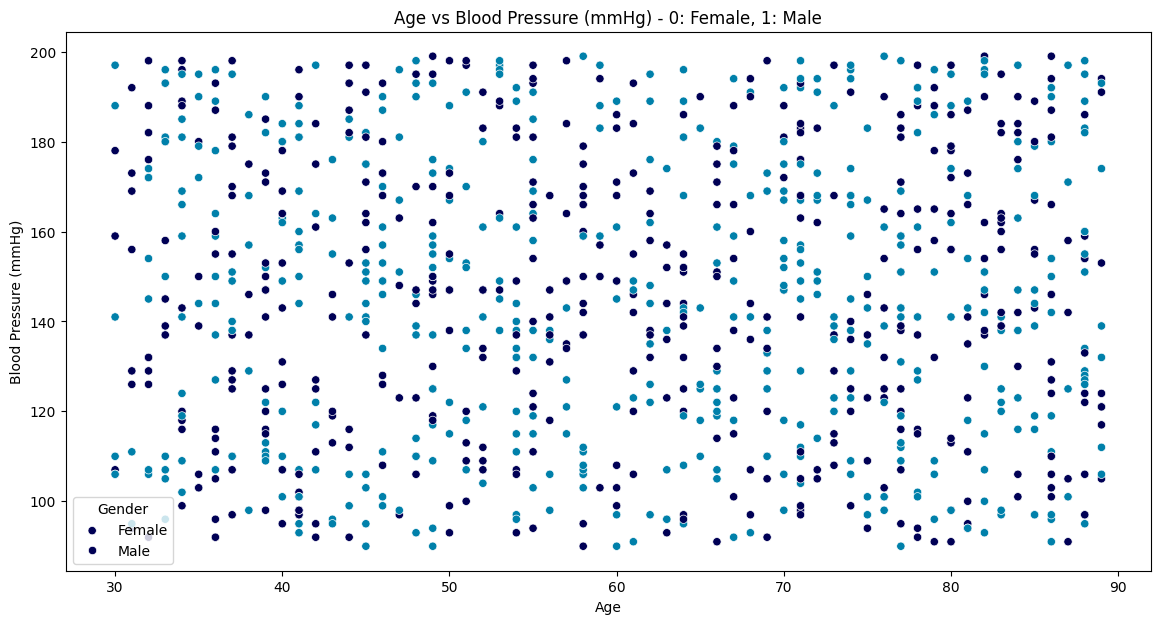

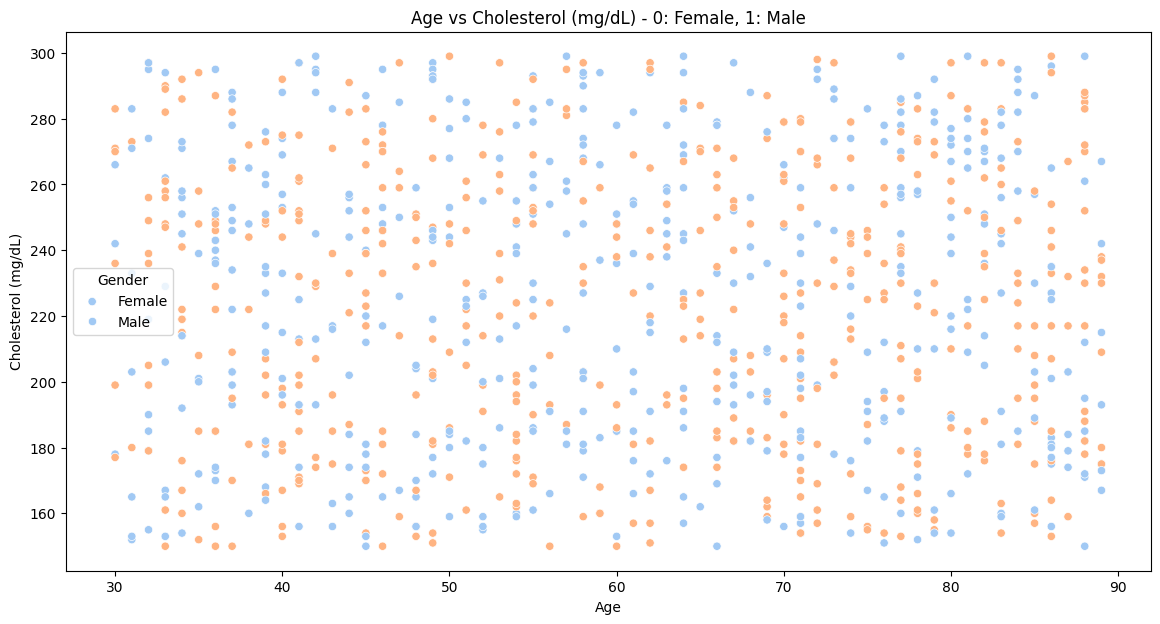

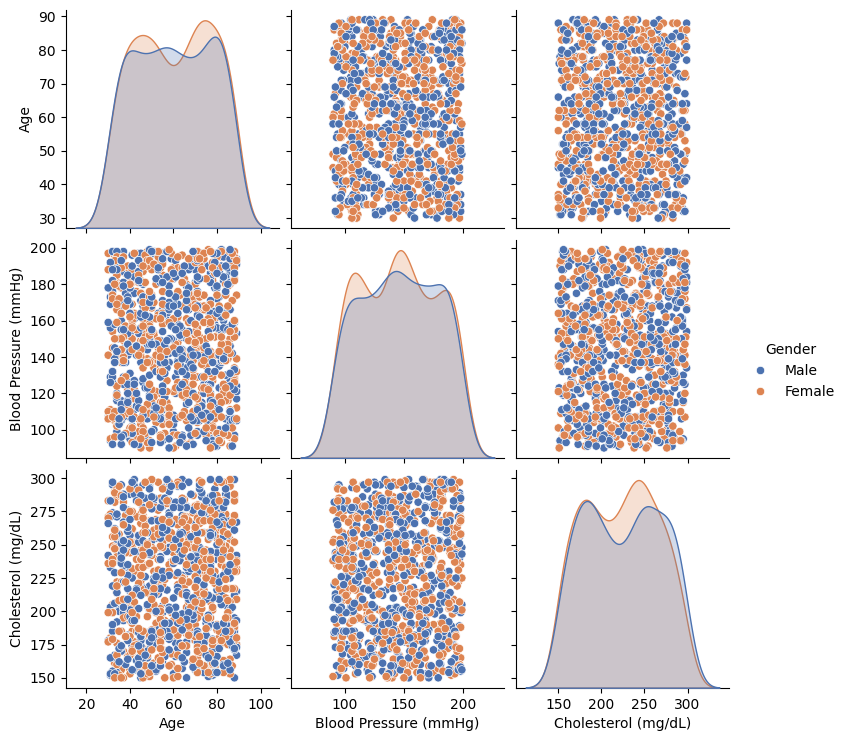

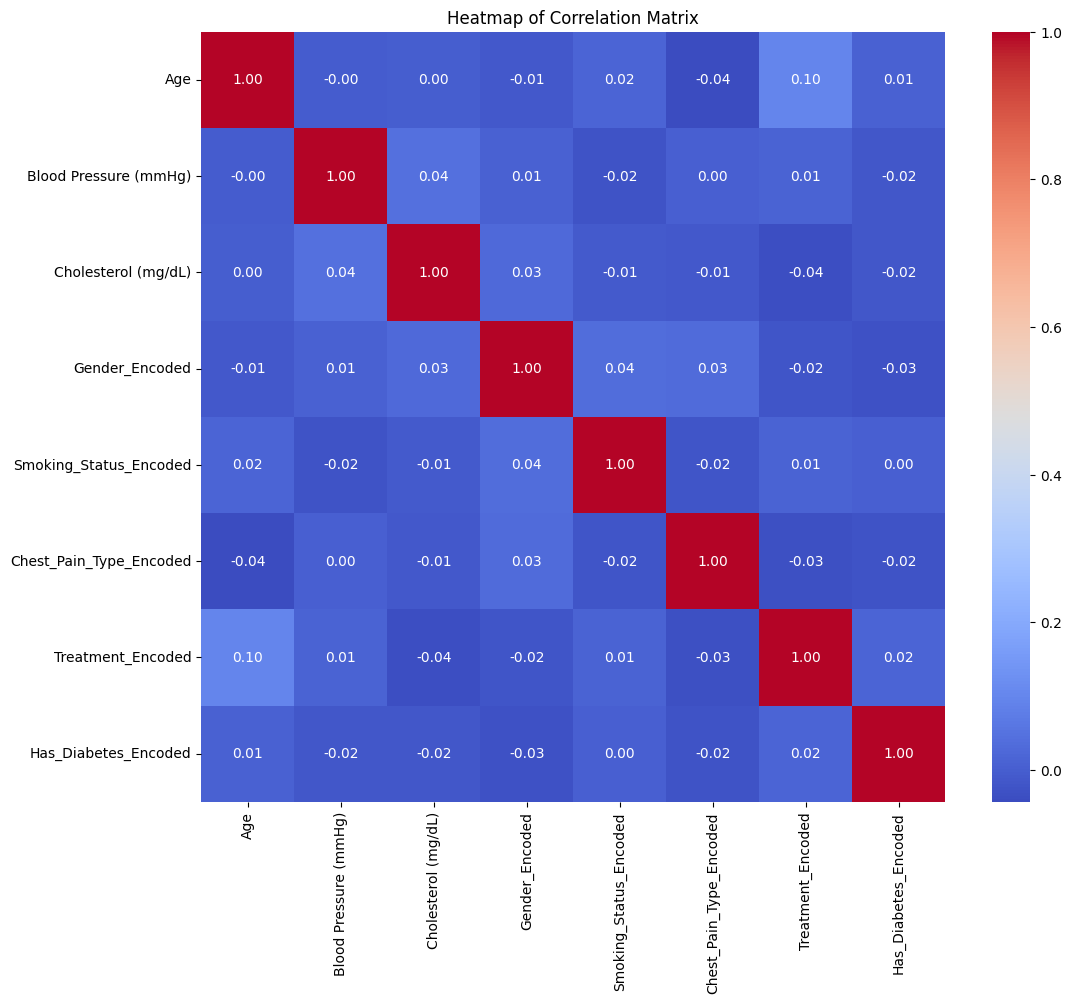

In [ ]:
# ----------------------------
# Step 5: Data Visualization
# ----------------------------
plt.figure(figsize=(20, 6))
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

sns.countplot(x='Gender', hue='Has Diabetes', data=df)
plt.title('Gender Count with Diabetes as Key')
plt.xlabel("Gender")
plt.ylabel('Count')
plt.xticks([0, 1], ['Female', 'Male'])
plt.legend(title='Has Diabetes')
plt.show()

sns.countplot(x='Gender', hue='Smoking Status', data=df)
plt.title("Gender Count with Smoking Status as Key")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks([0, 1], ['Female', 'Male'])
plt.legend(title='Smoking Status')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='Gender', y='Cholesterol (mg/dL)', data=df, palette='rocket')
plt.title("Gender vs Cholesterol (mg/dL)")
plt.xlabel("Gender")
plt.ylabel("Cholesterol (mg/dL)")
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='Smoking Status', y='Age', data=df, palette='rocket')
plt.title("Smoking Status vs Age")
plt.xlabel("Smoking Status")
plt.ylabel("Age")
plt.show()

plt.figure(figsize=(14, 7))
sns.scatterplot(x='Age', y='Blood Pressure (mmHg)', hue='Gender', data=df, palette='ocean')
plt.title("Age vs Blood Pressure (mmHg) - 0: Female, 1: Male")
plt.xlabel("Age")
plt.ylabel("Blood Pressure (mmHg)")
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.show()

plt.figure(figsize=(14, 7))
sns.scatterplot(x='Age', y='Cholesterol (mg/dL)', hue='Gender', data=df, palette='pastel')
plt.title("Age vs Cholesterol (mg/dL) - 0: Female, 1: Male")
plt.xlabel("Age")
plt.ylabel("Cholesterol (mg/dL)")
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.show()

sns.pairplot(data=df, hue='Gender', vars=['Age', 'Blood Pressure (mmHg)', 'Cholesterol (mg/dL)'], palette='deep')
plt.show()

corr_df = df[['Age', 'Blood Pressure (mmHg)', 'Cholesterol (mg/dL)', 'Gender_Encoded', 'Smoking_Status_Encoded', 'Chest_Pain_Type_Encoded', 'Treatment_Encoded', 'Has_Diabetes_Encoded']]
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Correlation Matrix")
plt.show()



In [ ]:
# ----------------------------
# Step 2: Data Preprocessing and Encoding
# ----------------------------
df.fillna(df.mean(numeric_only=True), inplace=True)

# Encoding categorical features
le = LabelEncoder()
df['Gender_Encoded'] = le.fit_transform(df['Gender'])
df['Smoking_Status_Encoded'] = le.fit_transform(df['Smoking Status'])
df['Chest_Pain_Type_Encoded'] = le.fit_transform(df['Chest Pain Type'])
df['Treatment_Encoded'] = le.fit_transform(df['Treatment'])
df['Has_Diabetes_Encoded'] = le.fit_transform(df['Has Diabetes'])


In [ ]:
# ----------------------------
# Step 3: Handling Imbalanced Data with SMOTE
# ----------------------------
feature_cols = ['Gender_Encoded', 'Age', 'Blood Pressure (mmHg)', 'Cholesterol (mg/dL)', 'Smoking_Status_Encoded', 'Chest_Pain_Type_Encoded', 'Treatment_Encoded']
X = df[feature_cols]
Y = df['Has_Diabetes_Encoded']


In [ ]:
# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [ ]:
# Apply SMOTE for oversampling the minority class in the training data
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)


In [ ]:
# ----------------------------
# Step 4: Feature Scaling
# ----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# ----------------------------
# Step 5: Feature Selection using Feature Importance from RandomForest
# ----------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, Y_train)
importance = rf.feature_importances_


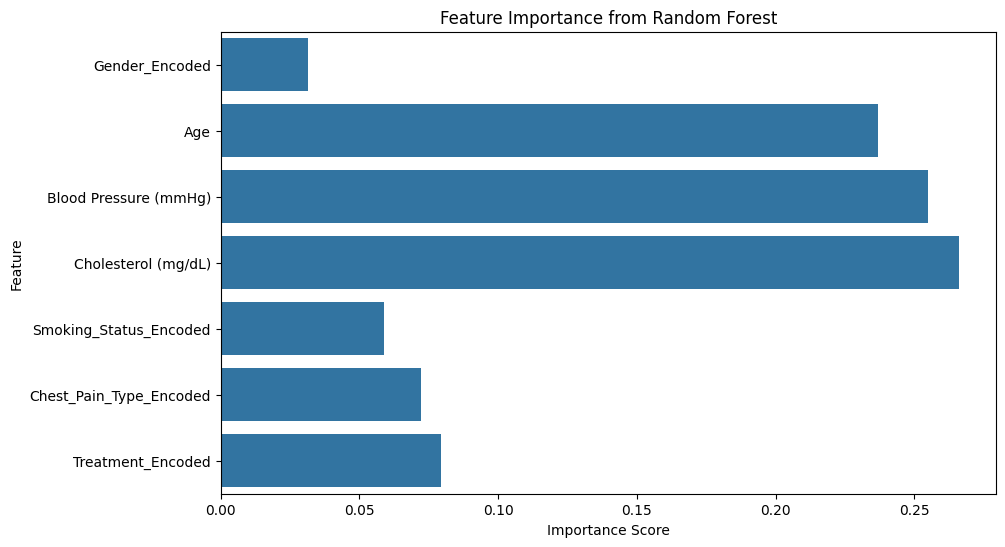

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=feature_cols)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

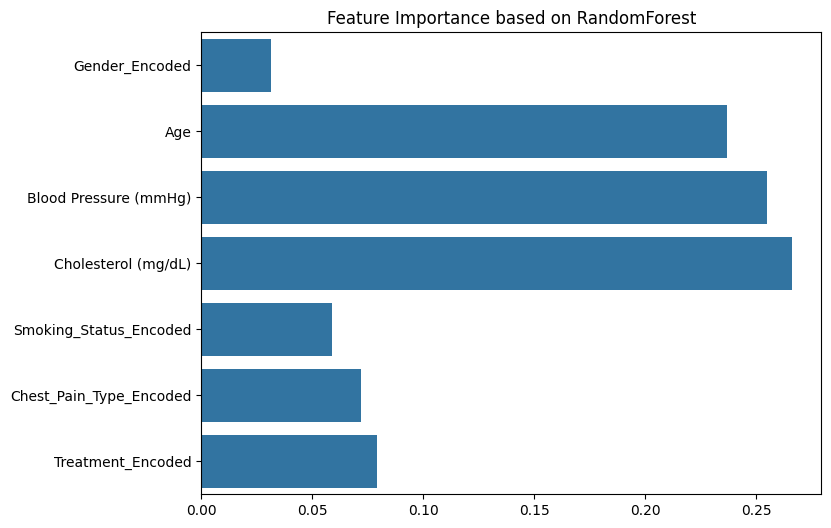

In [ ]:
# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=importance, y=feature_cols)
plt.title('Feature Importance based on RandomForest')
plt.show()


In [ ]:
# Choose the top 5 important features based on importance scores
important_features = np.argsort(importance)[::-1][:5]
X_train_imp = X_train[:, important_features]
X_test_imp = X_test[:, important_features]


In [ ]:
# ----------------------------
# Step 6: Hyperparameter Tuning with Cross-Validation using AUC-ROC
# ----------------------------
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7, 9]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, 3, 5]
}

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, 3, 5]
}


In [ ]:
# RandomForest
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_imp, Y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='roc_auc')

In [ ]:
# GradientBoosting
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_gb.fit(X_train_imp, Y_train)

# XGBoost
grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid_xgb, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train_imp, Y_train)

# LightGBM
grid_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_lgbm.fit(X_train_imp, Y_train)


[LightGBM] [Info] Number of positive: 409, number of negative: 409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 818, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc')

In [22]:
# ----------------------------
# Step 7: Ensemble Voting Model
# ----------------------------
# Define the base models for voting
voting_clf = VotingClassifier(estimators=[
    ('rf', grid_rf.best_estimator_),
    ('gb', grid_gb.best_estimator_),
    ('xgb', grid_xgb.best_estimator_),
    ('lgbm', grid_lgbm.best_estimator_)
], voting='soft', n_jobs=-1)

voting_clf.fit(X_train_imp, Y_train)



VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         max_depth=7,
                                                         random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopp...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.05, max_depth=7,
                                             n_estimators=300, random_state=42,
                                             scale_pos_weight=1))],
                 n_jobs=-1, voting='soft')

In [23]:
# ----------------------------
# Step 8: Model Evaluation
# ----------------------------
models = {
    'Random Forest (Tuned)': grid_rf.best_estimator_,
    'Gradient Boosting (Tuned)': grid_gb.best_estimator_,
    'XGBoost (Tuned)': grid_xgb.best_estimator_,
    'LightGBM (Tuned)': grid_lgbm.best_estimator_,
    'Voting Classifier (Ensemble)': voting_clf
}
# Store the results for comparison
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Predict on the test set
    Y_pred = model.predict(X_test_imp)
    roc_auc = roc_auc_score(Y_test, model.predict_proba(X_test_imp)[:, 1])
    accuracy = accuracy_score(Y_test, Y_pred)
    results[name] = {'Accuracy': accuracy, 'ROC-AUC': roc_auc}

    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{name} ROC-AUC: {roc_auc:.2f}")

    # Display confusion matrix
    print(f"{name} Confusion Matrix:")
    print(confusion_matrix(Y_test, Y_pred))

    # Display classification report
    print(f"{name} Classification Report:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)


Training Random Forest (Tuned)...
Random Forest (Tuned) Accuracy: 47.50%
Random Forest (Tuned) ROC-AUC: 0.46
Random Forest (Tuned) Confusion Matrix:
[[40 52]
 [53 55]]
Random Forest (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        92
           1       0.51      0.51      0.51       108

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.48      0.47      0.48       200

--------------------------------------------------
Training Gradient Boosting (Tuned)...
Gradient Boosting (Tuned) Accuracy: 43.50%
Gradient Boosting (Tuned) ROC-AUC: 0.41
Gradient Boosting (Tuned) Confusion Matrix:
[[45 47]
 [66 42]]
Gradient Boosting (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.49      0.44        92
           1       0.47      0.39      0.43       108

    accuracy

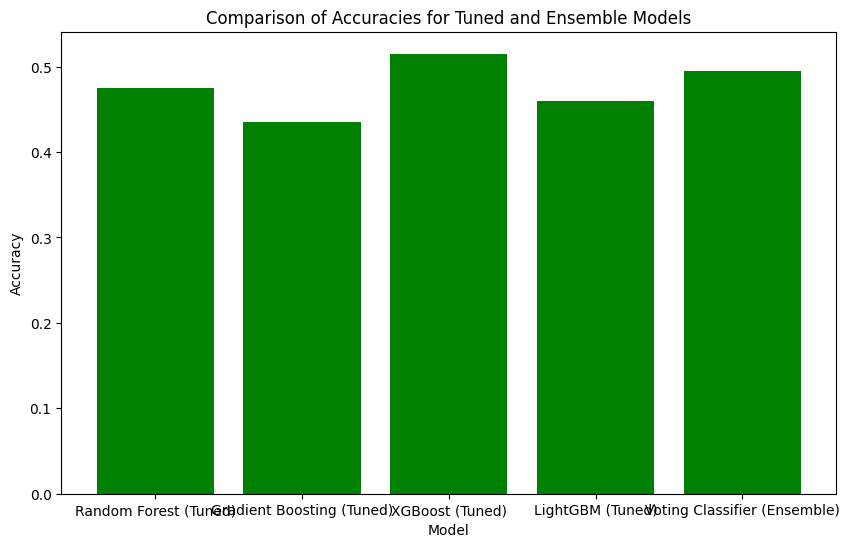

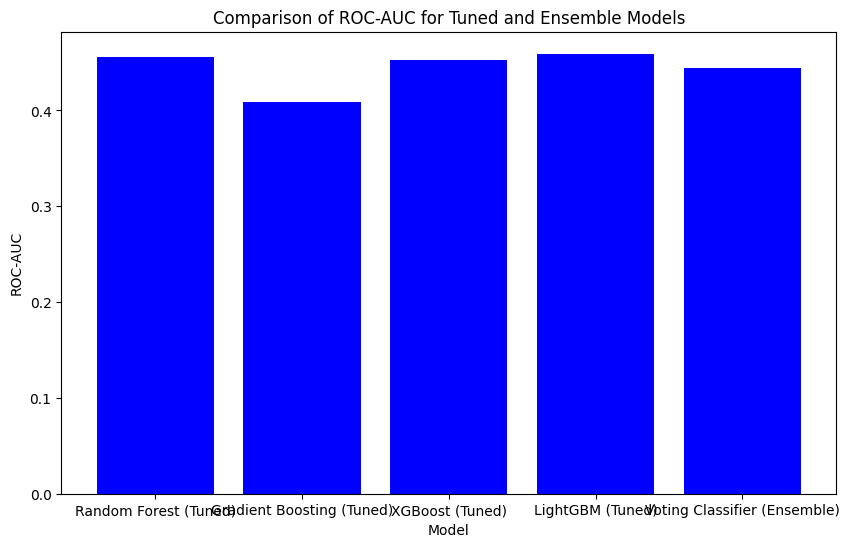

In [24]:
# ----------------------------
# Step 9: Comparison of Model Accuracies
# ----------------------------
model_names = list(results.keys())
accuracies = [results[model]['Accuracy'] for model in model_names]
roc_aucs = [results[model]['ROC-AUC'] for model in model_names]

# Separate Bar Chart for Accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='green', label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies for Tuned and Ensemble Models')
plt.show()

# Separate Bar Chart for ROC-AUC
plt.figure(figsize=(10, 6))
plt.bar(model_names, roc_aucs, color='blue', label='ROC-AUC')
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.title('Comparison of ROC-AUC for Tuned and Ensemble Models')
plt.show()


In [25]:
import pickle
pickle.dump(grid_lgbm, open('Lightgbm_model.pkl', 'wb'))

In [26]:
pickle.dump(grid_rf,open('rf_model.pkl', 'wb'))

In [27]:
pickle.dump(grid_gb,open('gb_model.pkl', 'wb'))

In [28]:
pickle.dump(grid_xgb,open('xgb_model.pkl', 'wb'))

In [29]:
pickle.dump(voting_clf,open('vclf_model.pkl', 'wb'))